# Fully connected network example for the CIFAR-10 classification task.
Classify image samples of the CIFAR-10 dataset using a fully-connected network

## CIFAR-10 Dataset
The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset.
They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.
see http://www.cs.toronto.edu/~kriz/cifar.html

Contains 6 files, each with 10000 shuffled images of 10 labeled classes.

The images are of size 32x32 pixels with 3 color channels (RGB).
The intensity in each channels is encoded as unsigned 8-bit integers 0...255.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
layers = tf.keras.layers

## Load and preprocess CIFAR-10 data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


### Pre-process data
normalize each pixel and color-channel separately across all images
take 2000 images for validation from test data

In [3]:
def normalize(images):
    mean = np.mean(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    sigma = np.std(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    images_normalized = (images - mean) / sigma
    return images_normalized

# take 2000 images for validation from test data
x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

#### One-hot encodings
convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on

In [4]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

## Define model

In [5]:
model = tf.keras.models.Sequential(
    [
        layers.Flatten(input_shape=(32, 32, 3)),  # (32,32,3) --> (3072)
        layers.Dense(10, activation="softmax"),
    ],
    name="nn",
)

print(model.summary()) # prints summary of the network architecture

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 10)                30730     
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None


2022-09-12 16:57:24.985519: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-12 16:57:24.985564: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zen): /proc/driver/nvidia/version does not exist
2022-09-12 16:57:24.986171: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"],
)

In [7]:
history = model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=20,
    verbose=1,
    validation_split=0.1,
)

Epoch 1/20


2022-09-12 16:57:25.398469: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 552960000 exceeds 10% of free system memory.


1407/1407 [==============================] - 2s 1ms/step - loss: 2.1263 - accuracy: 0.3234 - val_loss: 2.1038 - val_accuracy: 0.3352
Epoch 2/20
1407/1407 [==============================] - 2s 1ms/step - loss: 2.0508 - accuracy: 0.3491 - val_loss: 2.0869 - val_accuracy: 0.3492
Epoch 3/20
1407/1407 [==============================] - 2s 1ms/step - loss: 2.0126 - accuracy: 0.3579 - val_loss: 2.0786 - val_accuracy: 0.3368
Epoch 4/20
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9993 - accuracy: 0.3645 - val_loss: 2.1315 - val_accuracy: 0.3310
Epoch 5/20
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9927 - accuracy: 0.3667 - val_loss: 2.2232 - val_accuracy: 0.3248
Epoch 6/20
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9906 - accuracy: 0.3677 - val_loss: 2.1397 - val_accuracy: 0.3484
Epoch 7/20
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9826 - accuracy: 0.3697 - val_loss: 2.1371 - val_accuracy: 0.3218
Epo

## Plot training curves

### Loss

[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch')]

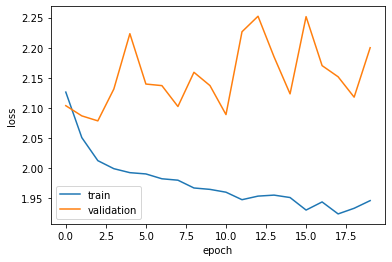

In [8]:
fig, ax = plt.subplots(1)
nb_epochs = np.arange(len(history.history["loss"]))
ax.plot(nb_epochs, history.history["loss"], label="train")
ax.plot(nb_epochs, history.history["val_loss"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="loss")

### Accuracy

[Text(0, 0.5, 'accuracy'), Text(0.5, 0, 'epoch')]

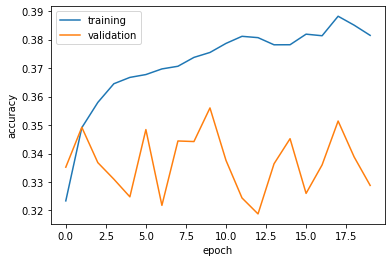

In [9]:
fig, ax = plt.subplots(1)
nb_epochs = np.arange(len(history.history["accuracy"]))
ax.plot(nb_epochs, history.history["accuracy"], label="training")
ax.plot(nb_epochs, history.history["val_accuracy"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="accuracy")

## Plot classifications using the test set
calculate predictions for test set and convert back to class labels (0-9)


In [10]:
def plot_prediction(X, Y, Y_predict, fname=False):
    labels = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
    
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, labels[i].capitalize(), ha="left", va="center", color=c)


In [11]:
y_predict = model.predict(x_test_norm, batch_size=128)

y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

In [12]:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images


/tmp/ipykernel_13194/1689623731.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  m = y_predict_cl == y_test_cl


#### Plot first 10 false classifications

In [13]:
fname = "false_%i_{}.png".format(model.name)
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i], fname=fname % i)



IndexError: invalid index to scalar variable.

#### Plot first 10 correct classifications

In [ ]:
fname = "correct_%i_{}.png".format(model.name)
for i in i1[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i], fname=fname % i)